In [1]:
from pnc_spks import *

### Look at the templates from kilosort

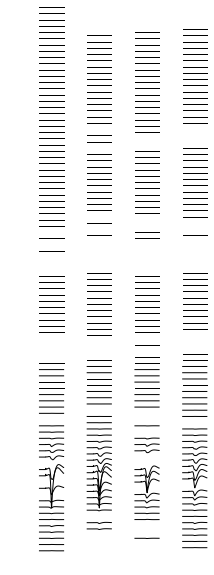

In [86]:
%matplotlib notebook
sortfolder = '/home/joao/data/ephys/raw/GetThatSpike_sync_g1'
# Cicle through kilosort templates
templates = np.load(pjoin(sortfolder,'templates.npy'))
# because templates are whitened
whiteningmat = np.load(pjoin(sortfolder,'whitening_mat_inv.npy'))
templates = np.dot(templates,whiteningmat)
# Read the channelmap
chmap = read_phy_channelmap(sortfolder)
xy = np.array(chmap[['x','y']])
fig = plt.figure(figsize=[3,10])
def plot_single_template(itemplate = 0):
    fig.clf()
    plot_footprints(templates[itemplate],
                    xy,
                    gain=[3,100]);
from ipywidgets import interact,widgets
interact(plot_single_template,itemplate = widgets.IntSlider(min=0,
                                           max=len(templates)-1,
                                           step=1,
                                           value=0));

### Get the spiketimes and average waveforms 

does not use template information

gets 100 random waveforms for each cluster


In [35]:
# Load the spiketimes and get average waveforms from the dat file
bin_file = pjoin(sortfolder,'GetThatSpike_sync_g1_t0.imec0.ap.bin')

spks = read_phy_data(sortfolder,bin_file=bin_file)
chmap = read_phy_channelmap(sortfolder)

Reading mean waveforms from the binary file.


In [45]:
# read sync channel
filename = '/home/joao/data/ephys/raw/GetThatSpike_sync_g1/GetThatSpike_sync_g1_t0.imec0.lf.bin'
dat,meta = load_spikeglx_binary(filename)
srate = meta['imSampRate']

onsets,offsets = unpack_npix_sync(dat[:,-1],srate);
# filter photodiode pulses due to improper placement
event_on_off = np.vstack([onsets[0],offsets[0]])
onsets[0] = onsets[0][np.where(np.diff(event_on_off,axis = 0).T> 1)[0]]
offsets[0] = offsets[0][np.where(np.diff(event_on_off,axis = 0).T> 1)[0]]
# Split in stimuli, because orientations are not randomized 
#we can split by taking the nth timestamp
nstims = 8
stim_onset = [onsets[0][i::nstims] for i in range(nstims)]
stim_dur = 2 # gratings on the screen for 2 seconds

### Spike triggered rasters

In [68]:
# compute triggered spike events for all units
trig_events = []
win = [-0.5,stim_dur + 0.5] # window to extract events
for sp in spks.ts.iloc[:]:
    trig_events.append([]) # one per unit
    for ons in stim_onset:
        tmp = []
        for on in ons:
            tmp.append(sp[(sp>win[0]+on) & (sp<win[1]+on)] - on)
        trig_events[-1].append(tmp) # one per stim

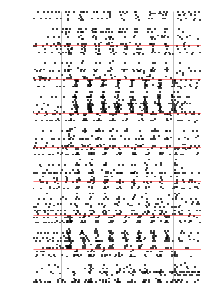

In [85]:
# plot the rasters
%matplotlib notebook

plt.figure(figsize=[3,5])
def interact_raster(iunit = 9):
    plt.cla()
    [plot_raster(t,offset = 20*o) for o,t in enumerate(trig_events[iunit])];
    plt.hlines(np.arange(nstims)*20,win[0],win[1],'r',lw = 0.5)
    plt.vlines([0,stim_dur],0,nstims*20,color = 'gray',lw = 0.5)
    plt.axis([win[0],win[1],0,nstims*20])
    plt.axis('off')
interact_raster(38)
from ipywidgets import interact,widgets
interact(interact_raster,iunit = widgets.IntSlider(min=0,
                                           max=len(trig_events)-1,
                                           step=1,
                                           value=38))

### Get random waveforms from a cluster

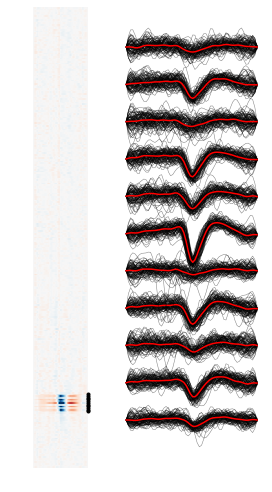

In [91]:
# get random sample of the waveforms for each cluster
filename = '/home/joao/data/ephys/raw/GetThatSpike_sync_g1/GetThatSpike_sync_g1_t0.imec0.ap.bin'
dat,meta = load_spikeglx_binary(filename)
srate = meta['imSampRate']

iunit = 38
waves = get_random_waveforms(dat,
                             np.array(chmap.ichan),
                             (spks.ts.iloc[iunit]*srate).astype(int),
                            npre = 30,npost=30)
mwaves = waves.mean(axis=0) # mean waveforms
ptb = mwaves.max(axis=0) - mwaves.min(axis=0) # peak to baseline per channel 
waveidx = np.where(np.abs((ptb-np.mean(ptb))/np.std(ptb))>1)[0] # "active" channels

# plot the figure
fig = plt.figure(figsize=[4,8])
axmean = fig.add_axes([0.1,0.1,0.2,0.8])
plt.axis('off')
axwaves = fig.add_axes([0.4,0.1,0.5,0.8])
plt.axis('off')

plt.sca(axmean)
plt.imshow(mwaves.T,cmap='RdBu_r',aspect = 'auto',origin='bottom',clim=[-20,20])
plt.plot(np.ones_like(waveidx)*mwaves.shape[0],waveidx,'.k')
offset = 50
plt.sca(axwaves)

for i,ich in enumerate(waveidx):
    plt.plot(waves[:,:,ich].T+
             offset*i,alpha = 0.5,lw=0.5,color = 'k')
    plt.plot(waves[:,:,ich].mean(axis=0).astype(np.float32)+
             offset*i,color='r');
